In [1]:
# The following code was adapted from a demo given by Andreas Krause in the course Probabilistic AI at ETH in 2021.

import numpy as np

import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import copy 

from rllib.environment.mdps import EasyGridWorld
from rllib.value_function import TabularValueFunction
from rllib.policy import TabularPolicy

environment = EasyGridWorld()
gamma = 0.9

# Plotters
def policy2str(policy):
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 == policy:
        policy_str += down 
    if 1 == policy:
        policy_str += up 
    if 2 == policy:
        policy_str += right
    if 3 == policy:
        policy_str += left
    return policy_str

def plot_value_function(value_function, ax):
    ax.imshow(value_function, vmin=-1, vmax=30)
    rows, cols = value_function.shape
    for row in range(rows):
        for col in range(cols):
            ax.text(row, col, f"{value_function[col, row]:.1f}", ha="center", va="center", color="w", fontsize=24)

def plot_policy(policy, ax):
    rows, cols = policy.shape
    ax.imshow(np.zeros((rows, cols)))
    for row in range(environment.height):
        for col in range(environment.width):
            ax.text(col, row, policy2str(policy[row, col]), ha="center", va="center", color="r", fontsize=24)

def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

    plot_value_function(value_function, axes[0])
    plot_policy(policy, axes[1])

## Task 1 - Policy Evaluation

(25, 25)
[[-0.909 12.903 -0.25   5.    -0.5   -0.323  0.     0.     0.    -0.25
  -0.25   0.     0.     0.    -0.25  -0.25   0.     0.     0.    -0.25
  -0.5   -0.25  -0.25  -0.25  -0.5  ]
 [-0.5   10.    -0.25   5.    -0.5   -0.25   0.     0.     0.    -0.25
  -0.25   0.     0.     0.    -0.25  -0.25   0.     0.     0.    -0.25
  -0.5   -2.5   -0.25  -0.25  -0.5  ]
 [-0.5   12.903 -0.323  6.452 -0.5   -0.25   0.     0.     0.    -0.25
  -0.25   0.     0.     0.    -0.25  -0.25   0.     0.     0.    -0.25
  -0.5   -0.25  -0.25  -0.25  -0.5  ]
 [-0.5   10.    -0.25   5.    -0.5   -0.25   0.     0.     0.    -0.25
  -0.25   0.     0.     0.    -0.25  -0.25   0.     0.     0.    -0.25
  -0.5   -0.25  -0.25  -0.25  -0.5  ]
 [-0.5   10.    -0.25   6.452 -0.909 -0.25   0.     0.     0.    -0.323
  -0.25   0.     0.     0.    -0.25  -0.25   0.     0.     0.    -0.25
  -0.5   -0.25  -0.25  -0.25  -0.5  ]
 [-0.645 10.    -0.25   5.    -0.5   -0.323  0.     0.     0.    -0.25
  -0.323  0.     0.

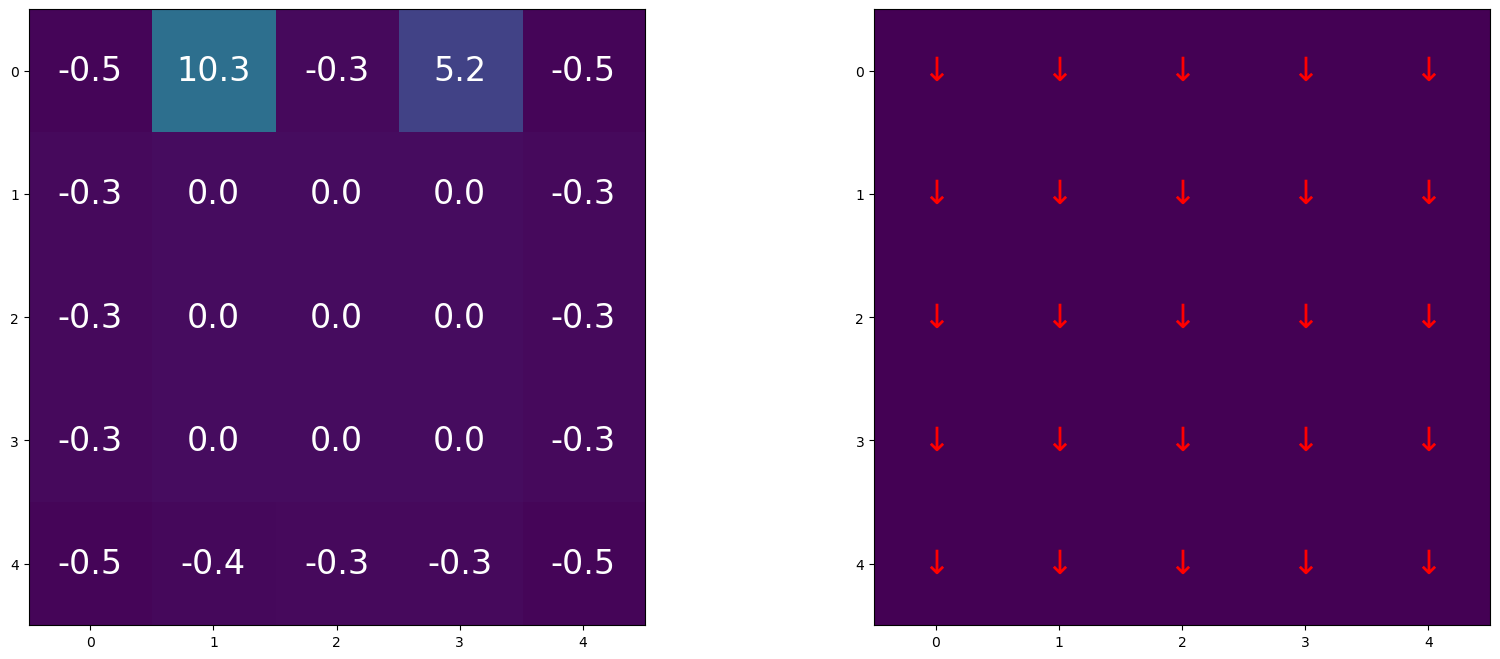

In [23]:
def init_policy_and_value_function():
    ### ---Task 1.1--- ###
    ### YOUR CODE HERE ###
    # initalize the policy with the number of states and actions given by the environment
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    # initalize the value_function with the number of states given by the environment
    value_function = TabularValueFunction(num_states=environment.num_states)
    
    ### YOUR CODE END  ###
    
    return policy, value_function

def linear_system_policy_evaluation(environment, policy, gamma, value_function):

    P, r = build_mrp_matrices(environment=environment, policy=policy)

    ### ---Task 1.2--- ###
    ### YOUR CODE HERE ###
    V = r / (1 - gamma*P)
    print(V.shape)
    print(V)
    v_sum = V.mean(axis=0)
    print(v_sum.shape)
    print(v_sum)
    vals = {}
    for state in range(environment.num_states):
        vals[state] = v_sum[state]
    
    print(vals)
    
    ### YOUR CODE END  ###    
    
    for state in range(environment.num_states):
        value_function.set_value(state, vals[state].item())

    return value_function

def build_mrp_matrices(environment, policy):
    mrp_kernel = np.zeros((environment.num_states, environment.num_states))
    mrp_reward = np.zeros((environment.num_states))

    for state in range(environment.num_states):
        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for a, p_action in enumerate(policy_.probs):
            for transition in environment.transitions[(state.item(), a)]:
                with torch.no_grad():
                    p_ns = transition["probability"]
                    mrp_reward[state] += p_action * p_ns * transition["reward"]
                    mrp_kernel[state, transition["next_state"]
                               ] += p_action * p_ns

    return mrp_kernel, mrp_reward

### ---Task 1.3--- ###
policy, value_function = init_policy_and_value_function()
value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

## Task 2 - Policy Iteration

In [ ]:
# Policy Iteration
def policy_iteration(environment, gamma):
    """Implement Policy Iteration algorithm.

    Parameters
    ----------
    gamma: float.
        discount factor.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.3

    """
    
    policy, value_function = init_policy_and_value_function()
    

    while True:
        # Evaluate the policy.
        value_function = linear_system_policy_evaluation(environment, policy, gamma, value_function)

        policy_stable = True
        # iterate through all states
        for state in range(environment.num_states):
            # initialize values
            value_ = torch.zeros(environment.num_actions)
            
            # iterate through possible actions
            for action in range(environment.num_actions):
                value_estimate = 0
                
                # iterate through transitions
                for transition in environment.transitions[(state, action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    
                    ### ---Task 2.1--- ###
                    ### YOUR CODE HERE ###
                    
                    
                    ### YOUR CODE END

                value_[action] = value_estimate

            state = torch.tensor(state).long()
            old_policy = policy(state)
            old_action = torch.argmax(old_policy)

            action = torch.argmax(value_)
            policy.set_value(state, action)
            
            ### ---Task 2.2--- ###
            ### YOUR CODE HERE ###
            
            
            ### YOUR CODE END  ###

        if policy_stable:
            break

    return value_function, policy

### ---Task 2.3--- ###
value_function, policy = policy_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

## Task 3 - Value Iteration

In [ ]:
def value_iteration(environment, gamma, eps=1e-6, max_iter=1000):
    """Implement of Value Iteration algorithm.

    Parameters
    ----------
    gamma: float
        discount factor.
    eps: float 
        desired precision.
    max_iter: int 
        Max number of iterations. 
    value_function: TabularValueFunction, optional. 
        Initial value function. 
        
    Returns
    -------
    value_function: TabularValueFunction
        Optimal value function.
    policy: Tabular Policy 
        Optimal policy. 
    num_iter: int
        Number of iterations to reach `eps' accuracy. 

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.4

    """
    policy, value_function = init_policy_and_value_function()

    for num_iter in range(max_iter):
        error = 0

        old_value_function = copy.deepcopy(value_function)
        for state in range(environment.num_states):
            ### ---TASK 3.1--- ###
            ### YOUR CODE HERE ###

            
            ### YOUR CODE END ###
            
            for action in range(environment.num_actions):
                value_estimate = 0

                # In practice, we do not have access to environment.transitions, but only to samples of it!.
                for transition in environment.transitions[(state, action)]:  
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    transition_probability = transition["probability"]

                    ### ---TASK 3.2--- ###
                    ### YOUR CODE HERE ###

                    
                    ### YOUR CODE END ###

                
            state = torch.tensor(state).long()
            
            ### ---TASK 3.3--- ###
            ### YOUR CODE HERE ###

            
            ### YOUR CODE END ### 
            
            policy.set_value(state, action)

        if error < eps:
            break

    return value_function, policy, num_iter 



### ---Task 3.4--- ###
value_function, policy, num_iter = value_iteration(environment, gamma)
plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())
print(f"Iterations until convergence: {num_iter}")